In [127]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt 

# For legend
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load the FEMA data for PR

In [128]:
femaDf = pd.read_csv("../data/open-fema/FEMA-Large-DR-4339-PR.csv")
print(f"There are {len(femaDf)} records in the dataframe.")

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1122568 records in the dataframe.


In [129]:
femaDf.drop_duplicates(inplace=True)
print(f"There are {len(femaDf)} records after dropping any duplicates.")

There are 1122568 records after dropping any duplicates.


In [130]:
# Change incorrect datatype
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')
femaDf['censusBlockId'] = femaDf['censusBlockId'].astype('str').replace('\.0', '', regex=True)
print(f"habitabilityRepairsRequired datatype: {femaDf['habitabilityRepairsRequired'].dtype}")
print(f"primaryResidence datatype: {femaDf['primaryResidence'].dtype}")
print(f"censusBlockId datatype: {femaDf['censusBlockId'].dtype}")

habitabilityRepairsRequired datatype: bool
primaryResidence datatype: bool
censusBlockId datatype: object


In [131]:
# Create census tract IDs for FEMA dataset
femaDf['censusTractId'] = femaDf.apply(lambda row: row.censusBlockId[0:11], axis=1)
femaDf['county_fips'] = femaDf.apply(lambda row: row.censusBlockId[0:5], axis=1)
femaDf[['censusBlockId', 'censusTractId', 'county_fips']].head()

,censusBlockId,censusTractId,county_fips
0,nan,nan,nan
1,720310510021022,72031051002,72031
2,721031704003001,72103170400,72103
3,721390604042000,72139060404,72139
4,720439539002080,72043953900,72043


In [132]:
# Define all dollar amount columns, set them to zero if null
amountCols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
              'replacementAmount', 'repairAmount', 'rpfvl', 'ppfvl']

femaDf[amountCols] = femaDf[amountCols].fillna(0)

In [133]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']
femaDf[bool_cols] = femaDf[bool_cols].astype(int)

### Load demographics data

In [160]:
# Load demographics data
demoDf = pd.read_csv("../data/census-tract/census-tract-demographics.csv")
print(f"There are {len(demoDf)} records in the dataframe.")

There are 12650 records in the dataframe.


In [161]:
# Change to tractid datatype to string
demoDf['tractid'] = demoDf['tractid'].astype('str')
print(f"tractid datatype: {demoDf['tractid'].dtype}")

tractid datatype: object


In [162]:
# Select subset of variables
demoDf = demoDf[['censusid', 'tractid', 'tractname', 'county', 'state', 'total_population', 'below_poverty_rate', 'median_earnings_total',
                 'unemployed_labor_rate', 'bachelors_degree_rate','built_1979_or_earlier_rate', 'owner_occupied_rate']]

### Merge femaDf and demoDf

In [163]:
# Merge demographics and FEMA datasets
df = pd.merge(femaDf, demoDf, left_on='censusTractId', right_on='tractid')
print(f"There are {len(df)} records in the merged dataset.")
print(f"This is a {len(femaDf) - len(df)} difference b/w the original dataset and the merged.")

There are 1067075 records in the merged dataset.
This is a 55493 difference b/w the original dataset and the merged.


### Load wind-speed data for Hurricane Maria PR

In [164]:
windDataDf = pd.read_csv('../data/hurricane/ARA-wind-data/maria-wind-data-county.csv')
print(f"There are {len(windDataDf)} records in the dataframe.")

There are 7647 records in the dataframe.


In [165]:
# Change to tractid datatype to string
windDataDf['tract_id'] = windDataDf['tract_id'].astype('str')
windDataDf.rename(columns={'Vg (mph)': 'pwg_mph'}, inplace=True)

In [166]:
# Aggregate by tract
windDataTractDf = windDataDf.groupby(['tract_id']).agg(pwg_mph=('pwg_mph', 'mean')).reset_index()
print(f"There are {len(windDataTractDf)} records in the windDataTractDf dataframe.")

There are 756 records in the windDataTractDf dataframe.


In [167]:
# Create county averages 
windDataCountyDf = windDataDf.groupby(['county_fips']).agg(pwg_county_avg_mph=('pwg_mph', 'mean')).reset_index()
windDataCountyDf['county_fips'] = windDataCountyDf['county_fips'].astype('str')
print(f"There are {len(windDataCountyDf)} records in the windDataCountyDf dataframe.")

There are 78 records in the windDataCountyDf dataframe.


### Merge femaDf and windDataTractDf

In [168]:
# Merge FEMA dataset and wind-data
df = df.merge(windDataTractDf, left_on='censusTractId', right_on='tract_id', how='left')
df.drop('tract_id', inplace=True, axis=1)
print(f"There are {len(df)} records in the merged dataset.")

There are 1067075 records in the merged dataset.


In [169]:
print(f"There are {df['pwg_mph'].isna().sum()} missing wind-data observations.")
print(f"Here is a breakdown by county,")
df[df['pwg_mph'].isna()]['county'].value_counts()

There are 117135 missing wind-data observations.
Here is a breakdown by county,


San Juan Municipio         42936
Bayamón Municipio          14359
Carolina Municipio         11549
Caguas Municipio            7163
Cataño Municipio            5450
Ponce Municipio             5410
Guaynabo Municipio          4739
Toa Baja Municipio          3527
Trujillo Alto Municipio     3126
Camuy Municipio             2505
Yabucoa Municipio           2227
Coamo Municipio             1964
Mayagüez Municipio          1953
Arecibo Municipio           1802
Aguadilla Municipio         1670
Yauco Municipio             1170
Cayey Municipio              935
Vega Baja Municipio          799
Fajardo Municipio            780
Loíza Municipio              768
Guánica Municipio            617
Guayama Municipio            537
Añasco Municipio             456
Hormigueros Municipio        390
Gurabo Municipio             299
Pinellas County                1
Palm Beach County              1
Polk County                    1
Ceiba Municipio                1
Name: county, dtype: int64

### Use the county average wind speed for missing tracts

In [170]:
# Merge FEMA dataset and wind-data
df = df.merge(windDataCountyDf, on='county_fips', how='left')
print(f"There are {len(df)} records in the merged dataset.")

There are 1067075 records in the merged dataset.


### Drop uneeded columns and save results

In [171]:
df.drop(['renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode', 'censusBlockId', 'censusid', 'tractid'], 
        inplace=True, axis=1)

In [172]:
df.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'ownRent', 'residenceType', 'homeOwnersInsurance', 'floodInsurance',
       'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed',
       'waterLevel', 'floodDamage', 'foundationDamage',
       'foundationDamageAmount', 'roofDamage', 'roofDamageAmount',
       'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible',
       'rentalAssistanceAmount', 'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl', 'censusYear',
       'id', 'censusTractId', 'county_fips', 'tractname', 'county', 'state',
       'total_population', 'below_poverty_rate', 'median_earnings_total',
       'unemployed_labor_rate', 'bachelors_degree_rate',
       'built_1979_or_earlier_rate', 'owner_occupied_rate', 'pwg_mph',
    

In [173]:
df.to_csv('../data/open-fema/FEMA-Large-Demographics-WindSpeed-PR.csv', index=False, encoding='utf-8')
print('{} rows saved to: {}'.format(len(df), '../data/open-fema/FEMA-Large-Demographics-WindSpeed-PR.csv'))

1067075 rows saved to: ../data/open-fema/FEMA-Large-Demographics-WindSpeed-PR.csv


### Visualize the waterLevel

In [150]:
# Calculate the mean waterLevel by Census tract
waterLevelTractDf = df.groupby(['censusTractId']).agg({'waterLevel': ['mean']}).reset_index()
waterLevelTractDf.columns = [col_name[0] for col_name in waterLevelTractDf.columns.to_flat_index()]

In [151]:
waterLevelTractDf['waterLevel'].describe()

count    895.000000
mean       0.761572
std        2.316534
min        0.000000
25%        0.071498
50%        0.176611
75%        0.487058
max       33.722397
Name: waterLevel, dtype: float64

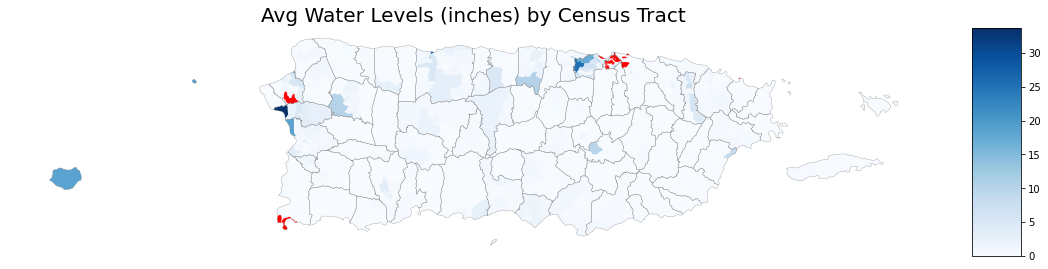

In [157]:
# Load shapefiles for PR
census_tracts_shp = gpd.read_file('../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
county_shp = census_tracts_shp.dissolve(by=census_tracts_shp.columns[1], aggfunc='first')

# Merge the dataframes for the tract level
census_tracts_shp = census_tracts_shp.merge(waterLevelTractDf, left_on='GEOID', right_on='censusTractId', how='left')
    
# Visualize
fig, ax = plt.subplots(figsize=(15, 10))

# Nice legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

census_tracts_shp.plot(column='waterLevel', ax=ax, legend=True, cmap='Blues', cax=cax,
                                      missing_kwds={'color': 'red', 'label': 'Missing values'})
county_shp.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=.3)

ax.set_title('Avg Water Levels (inches) by Census Tract', fontsize=20)
ax.axis('off')
plt.tight_layout()

### PR Flood Map

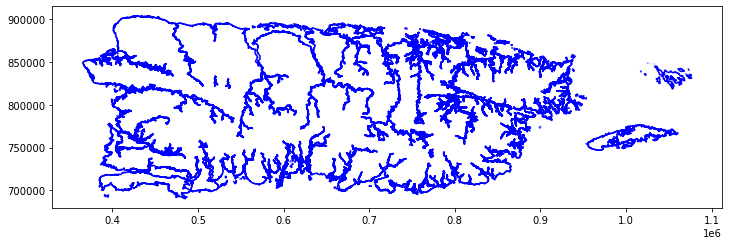

In [158]:
floodZone = gpd.read_file('../data/census-tract/flood-zone/FldZone_Line_1PCT_Seamless.shp')
floodZone.plot(figsize=(12,12), color='blue')